In [1]:
from glob import glob
from src import Module, DataModule
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import numpy as np
import pandas as pd

In [2]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/baseline_flips_crops_lr-val_f1=0.87500-epoch=13.ckpt',
 './checkpoints/baseline_flips_crops_lr-epoch=33.ckpt',
 './checkpoints/baseline-val_f1=0.83495-epoch=7.ckpt']

In [3]:
name = "baseline_flips_crops_lr-val_f1=0.87500-epoch=13.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module()
module.load_state_dict(state_dict)


<All keys matched successfully>

In [4]:
def eval(model, device=0, th=0.5):
	dm = DataModule()
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.F1Score(task="binary", threshold=th).cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = model(x.cuda(device))
			metric(y_hat, y.cuda(device).float())
			f1 = metric.compute().cpu().item()
			pbar.set_description(f'F1: {f1:.5f}')
	return f1

In [5]:
eval(module)

F1: 0.87500: 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]


0.875

Threshold tuning

In [6]:
thresholds = np.linspace(0.1, 0.9, 10)
data = []
for th in thresholds:
	print(f"Threshold: {th}")
	dice = eval(module, th=th)
	data.append((th, dice))

Threshold: 0.1


F1: 0.76667: 100%|██████████| 32/32 [00:01<00:00, 18.69it/s]


Threshold: 0.18888888888888888


F1: 0.79279: 100%|██████████| 32/32 [00:01<00:00, 18.67it/s]


Threshold: 0.2777777777777778


F1: 0.83495: 100%|██████████| 32/32 [00:01<00:00, 18.91it/s]


Threshold: 0.3666666666666667


F1: 0.85149: 100%|██████████| 32/32 [00:01<00:00, 18.72it/s]


Threshold: 0.4555555555555556


F1: 0.88660: 100%|██████████| 32/32 [00:01<00:00, 18.39it/s]


Threshold: 0.5444444444444445


F1: 0.87500: 100%|██████████| 32/32 [00:01<00:00, 18.77it/s]


Threshold: 0.6333333333333333


F1: 0.84783: 100%|██████████| 32/32 [00:01<00:00, 18.92it/s]


Threshold: 0.7222222222222222


F1: 0.85714: 100%|██████████| 32/32 [00:01<00:00, 18.86it/s]


Threshold: 0.8111111111111111


F1: 0.83146: 100%|██████████| 32/32 [00:01<00:00, 18.71it/s]


Threshold: 0.9


F1: 0.80460: 100%|██████████| 32/32 [00:01<00:00, 18.59it/s]


<Axes: xlabel='Threshold'>

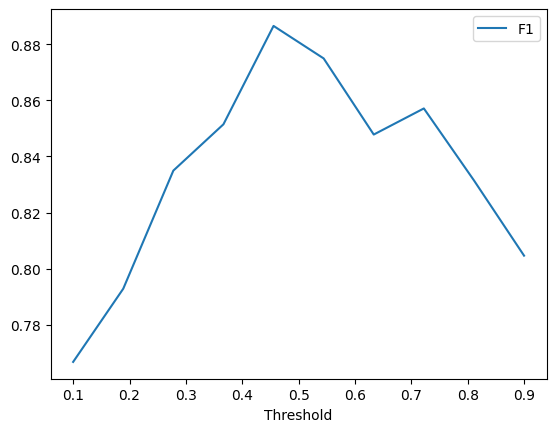

In [7]:
df = pd.DataFrame(data, columns=["Threshold", "F1"])
df.plot(x="Threshold", y="F1")

In [8]:
# get threhsold with best dice

best_th = df[df.F1 == df.F1.max()].Threshold.values[0]
best_th

0.4555555555555556

In [9]:
def generate_predictions(model, device=1, th=0.5):
	dm = DataModule()
	dm.setup()
	test_dl = dm.test_dataloader()
	model.eval()
	model.cuda(device)
	data = []
	with torch.no_grad():
		for batch in tqdm(test_dl):
			x, image_names = batch
			y_hat = model(x.cuda(device))
			y_hat = torch.sigmoid(y_hat) > th
			y_hat = y_hat.long().cpu().numpy()
			for i, image_name in enumerate(image_names):
				data.append((image_name, y_hat[i]))
	return pd.DataFrame(data, columns=["image_name", "label"])

In [10]:
df = generate_predictions(module, th=best_th)

100%|██████████| 156/156 [00:04<00:00, 38.78it/s]


In [11]:
df['id'] = df.image_name.apply(lambda x: int(x.split(".")[0].split("_")[1]))
df = df.sort_values("id")
df = df.drop(columns="id")
df

,image_name,label
385,evaluation_0.tif,0
1041,evaluation_1.tif,0
1135,evaluation_2.tif,0
288,evaluation_3.tif,0
712,evaluation_4.tif,1
...,...,...
130,evaluation_1238.tif,0
570,evaluation_1239.tif,0
596,evaluation_1240.tif,1
144,evaluation_1241.tif,0


In [12]:
df.to_csv("submission.csv", index=False, header=False)

In [13]:
df.label.value_counts()

0    993
1    250
Name: label, dtype: int64